# Import requirements

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 26.6 MB/s 
     |████████████████████████████████| 7.6 MB 81.2 MB/s 
     |████████████████████████████████| 182 kB 88.2 MB/s 


In [2]:
import os
import pdb
import argparse
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict

import torch
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from tqdm import tqdm, trange

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoConfig,
    AdamW
)

#new model
from transformers import (

    AutoModelForSequenceClassification,
    AutoTokenizer,

)

# 1. Preprocess

In [3]:
def make_id_file(task, tokenizer):
    def make_data_strings(file_name):
        data_strings = []
        with open(os.path.join(file_name), 'r', encoding='utf-8') as f:
            id_file_data = [tokenizer.encode(line.lower()) for line in f.readlines()]
        for item in id_file_data:
            data_strings.append(' '.join([str(k) for k in item]))
        return data_strings
    
    print('it will take some times...')
    train_pos = make_data_strings('sentiment.train.1')
    train_neg = make_data_strings('sentiment.train.0')
    dev_pos = make_data_strings('sentiment.dev.1')
    dev_neg = make_data_strings('sentiment.dev.0')

    print('make id file finished!')
    return train_pos, train_neg, dev_pos, dev_neg

In [4]:
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [5]:
from google.colab import files
uploaded = files.upload()

Saving sentiment.dev.0 to sentiment.dev.0
Saving sentiment.dev.1 to sentiment.dev.1
Saving sentiment.train.0 to sentiment.train.0
Saving sentiment.train.1 to sentiment.train.1
Saving test_no_label.csv to test_no_label.csv


In [6]:
!ls

sample_data	 sentiment.dev.1    sentiment.train.1
sentiment.dev.0  sentiment.train.0  test_no_label.csv


In [7]:
train_pos, train_neg, dev_pos, dev_neg = make_id_file('yelp', tokenizer)

it will take some times...
make id file finished!


In [8]:
train_pos[:10]

['2 5977 950 13 9 3',
 '2 18656 7705 365 13 9 3',
 '2 59 67 57 1954 621 18 17 1392 5262 56 25 510 254 13 9 3',
 '2 32 13 22 18 21 254 13865 69 20538 7298 13 9 3',
 '2 14 1138 25 4753 13 9 3',
 '2 254 748 950 13 9 3',
 '2 254 365 13 9 3',
 '2 11554 16 208 25 27269 17 7503 16 621 18 13 9 3',
 '2 374 209 26 4311 54 748 16385 18 17 3911 13 9 3',
 '2 14 78 978 1879 5289 13 9 3']

In [9]:
train_neg[:10]

['2 31 23 16382 15088 13 9 3',
 '2 86 27 20 14 20538 19008 13 15 14 1186 25 297 485 16 14 2238 13 9 3',
 '2 8663 4428 17 21 13 444 16 29081 408 2473 1105 13 9 3',
 '2 626 510 621 279 52 14358 16 14 5579 13 1 6336 1 2162 3383 13 9 3',
 '2 153 13 15 14 19360 20538 7298 13 15 32 25 35 661 9957 13 9 3',
 '2 31 41 20 1372 5579 13 1 6336 1 20 3547 7372 20 14 20538 7298 13 9 3',
 '2 39 470 55 80 23 21 1906 26 14 11669 27 14 270 13 9 3',
 '2 50 42 13838 55 13 60 3',
 '2 31 23 52 228 20 1372 26 14 11669 27 14 270 13 9 3',
 '2 31 1905 32 366 408 2473 1105 13 15 20 8844 13 15 27 5757 13 15 54 11669 13 9 3']

In [10]:
class SentimentDataset(object):
    def __init__(self, tokenizer, pos, neg):
        self.tokenizer = tokenizer
        self.data = []
        self.label = []

        for pos_sent in pos:
            self.data += [self._cast_to_int(pos_sent.strip().split())]
            self.label += [[1]]
        for neg_sent in neg:
            self.data += [self._cast_to_int(neg_sent.strip().split())]
            self.label += [[0]]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

In [11]:
train_dataset = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset = SentimentDataset(tokenizer, dev_pos, dev_neg)

In [12]:
for i, item in enumerate(train_dataset):
    print(item)
    if i == 10:
        break

(array([   2, 5977,  950,   13,    9,    3]), array([1]))
(array([    2, 18656,  7705,   365,    13,     9,     3]), array([1]))
(array([   2,   59,   67,   57, 1954,  621,   18,   17, 1392, 5262,   56,
         25,  510,  254,   13,    9,    3]), array([1]))
(array([    2,    32,    13,    22,    18,    21,   254, 13865,    69,
       20538,  7298,    13,     9,     3]), array([1]))
(array([   2,   14, 1138,   25, 4753,   13,    9,    3]), array([1]))
(array([  2, 254, 748, 950,  13,   9,   3]), array([1]))
(array([  2, 254, 365,  13,   9,   3]), array([1]))
(array([    2, 11554,    16,   208,    25, 27269,    17,  7503,    16,
         621,    18,    13,     9,     3]), array([1]))
(array([    2,   374,   209,    26,  4311,    54,   748, 16385,    18,
          17,  3911,    13,     9,     3]), array([1]))
(array([   2,   14,   78,  978, 1879, 5289,   13,    9,    3]), array([1]))
(array([  2,  48, 209,  23, 253, 254,  13,   9,   3]), array([1]))


In [13]:
def collate_fn_style(samples):
    input_ids, labels = zip(*samples)
    max_len = max(len(input_id) for input_id in input_ids)

    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],
                             batch_first=True)

    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])
    labels = torch.tensor(np.stack(labels, axis=0)[sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids, labels

In [14]:
train_batch_size=256 #batch size -> 32 to 256
eval_batch_size=512 #batch size -> 64 to 512

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=True, collate_fn=collate_fn_style,
                                           pin_memory=True, num_workers=2)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=eval_batch_size,
                                         shuffle=True, collate_fn=collate_fn_style, 
                                         num_workers=2)

In [15]:
# random seed
random_seed=42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained('albert-base-v2')
model.to(device)

Downloading:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [16]:
model.train()
learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps = 1e-6, weight_decay = 1e-2)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
def compute_acc(predictions, target_labels):
    return (np.array(predictions) == np.array(target_labels)).mean()

In [18]:
import matplotlib.pyplot as plt
import time
iter_x = []
max_iteration = 0
acc_y = []
loss_y = []

starttime = time.time()

In [19]:
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer = optimizer, lr_lambda = lambda epoch : 0.9** epoch, last_epoch=-1,verbose=False)
train_epoch = 3
lowest_valid_loss = 9999.
for epoch in range(train_epoch):
    with tqdm(train_loader, unit="batch") as tepoch:
        for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            position_ids = position_ids.to(device)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()

            # output = model(input_ids=input_ids,
            #                attention_mask=attention_mask,
            #                token_type_ids=token_type_ids,
            #                position_ids=position_ids,
            #                labels=labels)
            output = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        position_ids=position_ids,
                        labels=labels)

            loss = output.loss
            loss.backward()

            optimizer.step()

            tepoch.set_postfix(loss=loss.item())

            #### matplotlib ###
            if max_iteration < iteration:
                max_iteration = iteration
                if epoch>0:
                    assert False
            ### matplotlib ###

            if iteration != 0 and iteration % int(len(train_loader) / 10) == 0:
                # Evaluate the model five times per epoch
                with torch.no_grad():
                    model.eval()
                    valid_losses = []
                    predictions = []
                    target_labels = []
                    for input_ids, attention_mask, token_type_ids, position_ids, labels in tqdm(dev_loader,
                                                                                                desc='Eval',
                                                                                                position=1,
                                                                                                leave=None):
                        input_ids = input_ids.to(device)
                        attention_mask = attention_mask.to(device)
                        token_type_ids = token_type_ids.to(device)
                        position_ids = position_ids.to(device)
                        labels = labels.to(device, dtype=torch.long)

                        # output = model(input_ids=input_ids,
                        #                attention_mask=attention_mask,
                        #                token_type_ids=token_type_ids,
                        #                position_ids=position_ids,
                        #                labels=labels)
                        output = model(input_ids=input_ids,
                                        attention_mask=attention_mask,
                                        token_type_ids=token_type_ids,
                                        position_ids=position_ids,
                                        labels=labels)

                        logits = output.logits
                        loss = output.loss
                        valid_losses.append(loss.item())

                        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                        batch_labels = [int(example) for example in labels]

                        predictions += batch_predictions
                        target_labels += batch_labels

                acc = compute_acc(predictions, target_labels)
                valid_loss = sum(valid_losses) / len(valid_losses)

                ### matplotlib start ###
                
                iter_x.append(iteration)
                acc_y.append(acc)
                loss_y.append(valid_loss)
                
                ### matplotlib end ###
    
                if lowest_valid_loss > valid_loss:
                    print('Acc for model which have lower valid loss: ', acc)
                    torch.save(model.state_dict(), "./pytorch_model.bin")
                    lowest_valid_loss = valid_loss
        scheduler.step()

Epoch 0:  10%|█         | 174/1732 [00:51<21:36,  1.20batch/s, loss=0.112]

Acc for model which have lower valid loss:  0.964


Epoch 0:  20%|██        | 347/1732 [01:39<19:41,  1.17batch/s, loss=0.149]

Acc for model which have lower valid loss:  0.97075


Epoch 0:  30%|███       | 520/1732 [02:27<16:56,  1.19batch/s, loss=0.0723]

Acc for model which have lower valid loss:  0.97275


Epoch 0:  40%|████      | 693/1732 [03:15<14:38,  1.18batch/s, loss=0.0669]

Acc for model which have lower valid loss:  0.97125


Epoch 0:  50%|█████     | 866/1732 [04:04<11:54,  1.21batch/s, loss=0.0362]

Acc for model which have lower valid loss:  0.972


Epoch 0:  70%|██████▉   | 1212/1732 [05:40<07:21,  1.18batch/s, loss=0.0745]

Acc for model which have lower valid loss:  0.9745


Epoch 0:  80%|███████▉  | 1385/1732 [06:27<04:47,  1.21batch/s, loss=0.0507]

Acc for model which have lower valid loss:  0.976


Epoch 0: 100%|█████████▉| 1731/1732 [08:03<00:00,  1.18batch/s, loss=0.0649]

Acc for model which have lower valid loss:  0.977


Epoch 1:  20%|██        | 347/1732 [01:36<19:10,  1.20batch/s, loss=0.0545]

Acc for model which have lower valid loss:  0.977


Epoch 1:  30%|███       | 520/1732 [02:23<16:54,  1.19batch/s, loss=0.0415]

Acc for model which have lower valid loss:  0.9785


Epoch 1:  50%|█████     | 866/1732 [04:00<12:13,  1.18batch/s, loss=0.0461]

Acc for model which have lower valid loss:  0.9775


Epoch 1:  80%|███████▉  | 1385/1732 [06:24<04:54,  1.18batch/s, loss=0.0443]

Acc for model which have lower valid loss:  0.98025


Epoch 1:  90%|████████▉ | 1558/1732 [07:12<02:30,  1.16batch/s, loss=0.0566]

Acc for model which have lower valid loss:  0.981


Epoch 2:  40%|████      | 693/1732 [03:11<14:35,  1.19batch/s, loss=0.025]

Acc for model which have lower valid loss:  0.98175


Epoch 2: 100%|█████████▉| 1731/1732 [08:00<00:00,  1.19batch/s, loss=0.0314]

Acc for model which have lower valid loss:  0.982


Epoch 2: 100%|██████████| 1732/1732 [08:00<00:00,  3.60batch/s, loss=0.0942]


In [20]:
endtime = time.time()

In [21]:
import pandas as pd
test_df = pd.read_csv('test_no_label.csv')

In [22]:
test_dataset = test_df['Id']

In [23]:
def make_id_file_test(tokenizer, test_dataset):
    data_strings = []
    id_file_data = [tokenizer.encode(sent.lower()) for sent in test_dataset]
    for item in id_file_data:
        data_strings.append(' '.join([str(k) for k in item]))
    return data_strings

In [24]:
test = make_id_file_test(tokenizer, test_dataset)

In [25]:
test[:10]

['2 32 13 22 18 21 979 78 1496 17 78 11974 18 206 85 42 162 13 9 3',
 '2 86 17841 37 40 315 3839 13 9 3',
 '2 32 25 14 127 14351 7804 19 14 1152 13 9 3',
 '2 107 52 1676 21 9140 29 158 148 13 9 3',
 '2 31 23 4741 17 39 117 55 583 86 5733 17 5575 13 9 3',
 '2 14 104 584 95 420 30 23 1047 23 14 2364 13 9 3',
 '2 90 13 15 52 14 53 18 35 28 291 13 15 14 53 18 19 1630 183 13 9 3',
 '2 59 1499 32 70 431 26 42 17 50 253 15600 13 9 3',
 '2 3123 14 13533 144 13 103 22 38 166 143 184 20 170 14 1428 13 9 3',
 '2 59 57 40 5977 3155 16 22621 18 20 3538 37 13 9 3']

In [26]:
class SentimentTestDataset(object):
    def __init__(self, tokenizer, test):
        self.tokenizer = tokenizer
        self.data = []

        for sent in test:
            self.data += [self._cast_to_int(sent.strip().split())]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample)

In [27]:
test_dataset = SentimentTestDataset(tokenizer, test)

In [28]:
def collate_fn_style_test(samples):
    input_ids = samples
    max_len = max(len(input_id) for input_id in input_ids)

    #sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1] #bug
    sorted_indices = [i for i in range(len(input_ids))]
    
    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids

In [29]:
test_batch_size = 32
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size,
                                          shuffle=False, collate_fn=collate_fn_style_test,
                                          num_workers=2)

In [30]:
with torch.no_grad():
    model.eval()
    predictions = []
    ex0 = []
    ex1 = []
    for input_ids, attention_mask, token_type_ids, position_ids in tqdm(test_loader,
                                                                        desc='Test',
                                                                        position=1,
                                                                        leave=None):

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        position_ids = position_ids.to(device)

        # output = model(input_ids=input_ids,
        #                attention_mask=attention_mask,
        #                token_type_ids=token_type_ids,
        #                position_ids=position_ids)
        output = model(input_ids=input_ids,
                      attention_mask=attention_mask,
                      token_type_ids=token_type_ids,
                      position_ids=position_ids)

        logits = output.logits
        print(logits)
        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
        ex0 += [example[0].cpu().numpy() for example in logits]
        ex1 += [example[1].cpu().numpy() for example in logits]
        predictions += batch_predictions


Test:  19%|█▉        | 6/32 [00:00<00:01, 25.37it/s]

tensor([[-4.3609,  3.9265],
        [ 4.0724, -3.5755],
        [-4.3345,  3.6316],
        [ 4.0720, -3.6833],
        [-3.5029,  3.2510],
        [ 3.3409, -2.9291],
        [ 3.5696, -3.1912],
        [-3.9439,  3.4291],
        [ 3.5936, -3.2981],
        [-4.3957,  3.9428],
        [-4.4676,  4.0394],
        [ 4.0663, -3.6743],
        [ 2.8022, -2.0683],
        [-4.3216,  3.8695],
        [-4.0992,  3.6008],
        [ 4.0457, -3.6595],
        [ 0.3358,  0.0244],
        [-4.1423,  3.5779],
        [ 3.5540, -3.2168],
        [ 4.0514, -3.6786],
        [ 3.3344, -2.7497],
        [-3.9736,  3.4725],
        [ 3.3614, -3.0362],
        [-4.5204,  3.9973],
        [ 3.1526, -2.4437],
        [ 2.7453, -1.9969],
        [-2.3069,  2.2409],
        [-2.6944,  2.7996],
        [ 1.1362, -0.5138],
        [ 4.0231, -3.6232],
        [ 4.0403, -3.6874],
        [ 3.5130, -3.1563]], device='cuda:0')
tensor([[ 4.0336, -3.6382],
        [ 4.0342, -3.7010],
        [ 3.7434, -3.3994],
  


Test:  50%|█████     | 16/32 [00:00<00:00, 36.70it/s]

tensor([[-3.3073,  3.1599],
        [ 3.0504, -2.1891],
        [-4.4670,  3.7842],
        [-4.0142,  3.4733],
        [-3.2658,  2.9087],
        [ 3.3686, -2.9331],
        [-3.9262,  3.4153],
        [ 3.3788, -2.7207],
        [-4.7258,  4.1174],
        [ 1.9826, -1.0095],
        [-3.0487,  2.6968],
        [ 3.6318, -3.2031],
        [ 3.0276, -2.2907],
        [ 2.3686, -1.5629],
        [-4.2310,  3.7252],
        [ 3.1646, -2.5093],
        [ 3.8727, -3.5286],
        [-4.3887,  3.7307],
        [ 2.5593, -1.7420],
        [-3.9985,  3.4345],
        [-1.1128,  1.6183],
        [ 2.6899, -1.8535],
        [ 3.0702, -2.5692],
        [ 3.3374, -2.8436],
        [ 4.0542, -3.6481],
        [ 3.6462, -3.2386],
        [-4.5278,  3.8755],
        [ 3.9148, -3.5447],
        [ 3.9543, -3.6291],
        [ 3.5799, -3.3177],
        [ 2.6056, -1.8778],
        [-4.6555,  4.0722]], device='cuda:0')
tensor([[ 2.2534, -1.5095],
        [-4.5119,  4.2167],
        [-4.5903,  3.9838],
  


Test:  81%|████████▏ | 26/32 [00:00<00:00, 40.32it/s]

tensor([[ 4.0344, -3.6781],
        [-3.7127,  3.2850],
        [ 3.3130, -2.7856],
        [ 4.0054, -3.6961],
        [ 3.4230, -2.9125],
        [-2.7565,  2.7962],
        [ 3.5641, -3.3642],
        [-4.4094,  3.7320],
        [ 3.9925, -3.6767],
        [ 4.0336, -3.6571],
        [ 3.4929, -3.0743],
        [ 3.6355, -3.3573],
        [ 3.4168, -3.0478],
        [-3.9420,  3.4894],
        [ 2.6645, -1.8459],
        [-4.6160,  3.9895],
        [-4.4356,  3.9637],
        [ 3.6819, -3.3810],
        [ 1.9169, -1.1557],
        [ 3.6590, -3.2713],
        [ 3.7506, -3.3046],
        [ 3.6174, -3.2495],
        [-3.5490,  3.1524],
        [ 4.0188, -3.6796],
        [ 4.0617, -3.6919],
        [-4.7594,  4.0790],
        [ 2.2031, -1.4460],
        [-4.6200,  4.0445],
        [ 3.1008, -2.4586],
        [-2.7792,  2.5018],
        [ 4.0219, -3.5999],
        [-3.2679,  2.7641]], device='cuda:0')
tensor([[ 1.9671, -1.2377],
        [-4.5953,  3.9661],
        [-3.5922,  3.2037],
  


Test:  97%|█████████▋| 31/32 [00:00<00:00, 41.65it/s]
                                                     

tensor([[ 3.6633, -3.1746],
        [-3.5292,  3.2189],
        [-4.1029,  3.6936],
        [-4.7045,  4.1227],
        [-4.6026,  3.9559],
        [-4.6522,  4.0089],
        [-3.6941,  3.1642],
        [ 4.0492, -3.6917],
        [-4.5016,  3.9087],
        [ 3.3132, -2.7042],
        [-4.4176,  3.7654],
        [ 0.2200,  0.3548],
        [-4.4758,  3.9004],
        [-3.5438,  3.1586],
        [ 4.0599, -3.6919],
        [ 0.4439,  0.0831],
        [-4.6255,  3.9463],
        [ 4.0484, -3.7043],
        [-0.7293,  1.2291],
        [ 4.0114, -3.5707],
        [ 3.9822, -3.6905],
        [-3.1372,  2.8568],
        [ 2.7229, -2.0422],
        [ 3.8193, -3.5680],
        [-2.0215,  1.9143],
        [-4.6688,  3.9683],
        [ 3.0468, -2.3793],
        [ 3.1037, -2.3656],
        [ 2.8457, -2.0915],
        [ 3.9605, -3.5019],
        [-4.0941,  3.5488],
        [-2.1552,  2.2328]], device='cuda:0')
tensor([[-3.7591,  3.1739],
        [ 3.9051, -3.5298],
        [ 0.0678,  0.3660],
  

In [31]:
test_df['Category'] = predictions

In [32]:
test_df.to_csv('submission_albert_base_v2.csv', index=False)

In [33]:
test_df['ex0'] = ex0
test_df['ex1'] = ex1
test_df.to_csv('roberta_base_uncased_softvoting.csv', index=False)

In [34]:
print(lowest_valid_loss)

0.05067292042076588


In [35]:
print(iter_x)
print(acc_y)
print(loss_y)
print(max_iteration)
iter_x_save = iter_x

[173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730]
[0.964, 0.97075, 0.97275, 0.97125, 0.972, 0.971, 0.9745, 0.976, 0.9755, 0.977, 0.976, 0.977, 0.9785, 0.978, 0.9775, 0.97625, 0.97775, 0.98025, 0.981, 0.971, 0.97925, 0.97975, 0.97825, 0.98175, 0.9805, 0.9775, 0.97275, 0.979, 0.98025, 0.982]
[0.1182350805029273, 0.0896211857907474, 0.08034705789759755, 0.07825107499957085, 0.07351182354614139, 0.08518651593476534, 0.06619156338274479, 0.06401538103818893, 0.06545668747276068, 0.06167365284636617, 0.06284878589212894, 0.06096208933740854, 0.058816907461732626, 0.05919000180438161, 0.05721563007682562, 0.06101540429517627, 0.05723386164754629, 0.05603888304904103, 0.05352439405396581, 0.07751003000885248, 0.059832518454641104, 0.055545558920130134, 0.05617465917021036, 0.05268009100109339, 0.05532769998535514, 0.05957412859424949, 0.0659640645608306, 0.0533503326587379, 0.053

In [36]:
cnt = 0
for i in range(len(iter_x)):
    if cnt >= iter_x[i]:
        iter_x[i] = max_iteration + iter_x[i]
    cnt = iter_x[i]
cnt = 0
for i in range(len(iter_x)):
    if cnt >= iter_x[i]:
        iter_x[i] = max_iteration + iter_x[i]
    cnt = iter_x[i]
print(iter_x)

[173, 346, 519, 692, 865, 1038, 1211, 1384, 1557, 1730, 1904, 2077, 2250, 2423, 2596, 2769, 2942, 3115, 3288, 3461, 3635, 3808, 3981, 4154, 4327, 4500, 4673, 4846, 5019, 5192]


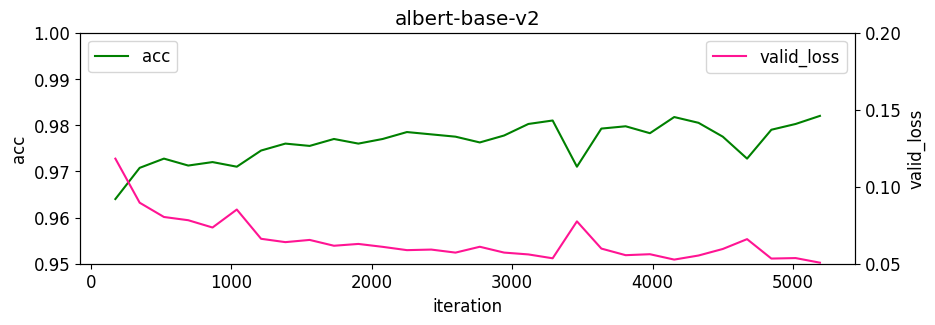

In [37]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 3)
plt.rcParams['font.size'] = 12

x = iter_x
y1 = acc_y
y2 = loss_y

fig, ax1 = plt.subplots()
ax1.set_xlabel('iteration')
ax1.set_ylabel('acc')
ax1.plot(x, y1, color='green',label='acc')
ax1.legend(loc='upper left')
ax1.set_ylim([0.950,1])

ax2 = ax1.twinx()
ax2.set_ylabel('valid_loss')
ax2.plot(x, y2, color='deeppink',label='valid_loss')
ax2.legend(loc='upper right')
ax2.set_ylim([0.05,0.2])

plt.title("albert-base-v2")

plt.show()

In [38]:
print(endtime - starttime)

1445.6984519958496
